# Predicting hotspots of burglaries

In this tutorial, hotspots of burglaries will be predicted in the city of Dallas. Three different models will be trained and their predictions will be validated.

Start by importing the hotspot library.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import date
import pandas as pd
import numpy as np

from predictivehp.models import Model, create_model
from predictivehp.visualization import Plotter
from predictivehp.utils import get_data, shps_processing

%config InlineBackend.figure_format = 'retina'

## Importing crime data

The tutorial will consider crime data provided by the City of Dallas. The data can be imported with the Socrata API. The street map and city limits can be obtained from Dallas City Hall (https://gis.dallascityhall.com/shapefileDownload.aspx). For convenience, the data has already been stored in the package.

In [ ]:
# CONSULTAR

# data = hp.import.tutorial('Dallas2017')
# The 'data' output is an instance of an object, which has all the relevant
# information and data such as a dataframe with incidences and shape files of
# the city. Either store the data in a folder or request data from Socrata with
# default parameters.

In general, data can be retrieved from the Socrata API and shape files can be specified as well.

In [ ]:
b_path = 'predictivehp/data'
s_shp_p = f'{b_path}/streets.shp'
c_shp_p = f'{b_path}/councils.shp'
cl_shp_p = f'{b_path}/citylimit.shp'

shps = shps_processing(s_shp_p, c_shp_p, cl_shp_p)
# data = read_pickle('predictivehp/data/data.pkl')
data = get_data(year=2017, n=150000)

The crime data is stored in a Pandas DataFrame where columns **x** and **y** are the location coordinates in meters and **date** the date of the crime event.

In [ ]:
data.head()

### Generate data

Alternatively to dowloading a data set from an external source, artificial data can be generated as well. This serves to test the performance of the algorithms.

In [3]:
# specify the limits of the domain
xlim = [0, 20]
ylim = [0, 15]

# specify the limits of the time period
from datetime import date
tstart = date(2020,1,1)
tlength = 70

In [4]:
# make several clusters of incidences
from sklearn.datasets import make_blobs
(incidences_space, cluster_label) = make_blobs(n_samples=[60,100,40], n_features=2,
                                               centers=[[5,5],[10,10],[15,4]],
                                               cluster_std=[1,5,0.5], random_state=0
                                              )

# remove incidences outside map
outside = []
for i in range(len(cluster_label)):
    x = incidences_space[i,0]
    y = incidences_space[i,1]
    if (x <= xlim[0]) or (x >= xlim[1]) or (y <= ylim[0]) or (y >= ylim[1]):
        outside.append(i)

incidences_space = np.delete(incidences_space, outside, axis=0)
cluster_label = np.delete(cluster_label, outside)

n_samples = len(cluster_label)

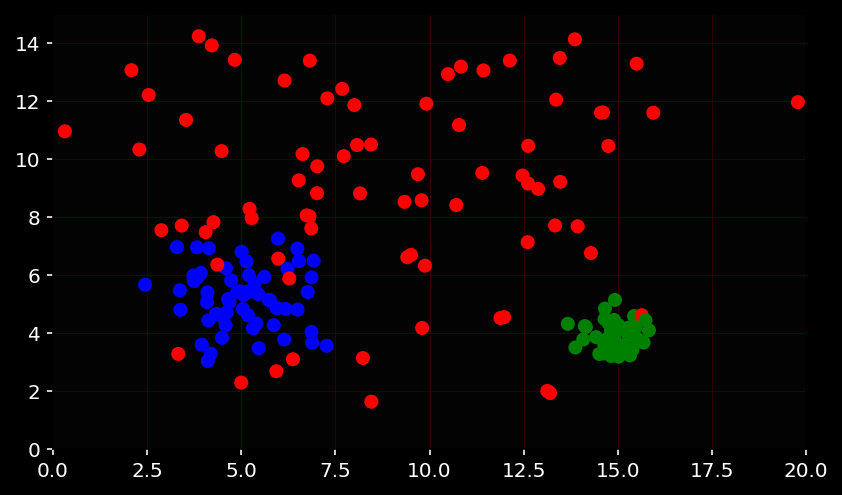

In [5]:
from matplotlib import pylab as plt

cmap = ['b','r','g']
colors = [cmap[i] for i in cluster_label]
plt.scatter(x=incidences_space[:,0], y=incidences_space[:,1],
            c=colors
           )
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

In [6]:
import random
random.seed(1)

n_samples = cluster_label.size

days = [random.randrange(tlength) for i in range(n_samples)]

days.sort()

from datetime import timedelta
dates = [tstart + timedelta(days=days[i]) for i in range(n_samples)]

In [7]:
incidences = [incidences_space[:,0], incidences_space[:,1], dates]
cols = ['x', 'y', 'date']
df = pd.DataFrame(data=incidences, index=cols).T

In [8]:
df

,x,y,date
0,7.26975,3.54563,2020-01-01
1,15.1373,3.55454,2020-01-01
2,5.06652,5.30247,2020-01-01
3,3.87282,14.2218,2020-01-02
4,5.98295,6.55225,2020-01-02
5,5.95009,4.84864,2020-01-02
6,3.29373,6.95078,2020-01-03
7,14.8177,4.07835,2020-01-03
8,15.0193,3.17164,2020-01-03
9,6.53278,6.46936,2020-01-03


## Specify the prediction configuration

Data has been loaded for the entire year of 2017. In this tutorial, the first week of November will be predicted from previous crime data. Since data is available for this week, the prediction can be validated as well.

All three available models, that is, STKDE, ProMap and Random Forest will be used for the prediction.

In [9]:
m = create_model(
    data=df,
    start_prediction=date(2020, 3, 4), length_prediction=7,
    use_stkde=True, use_promap=True, use_rfr=True,
)
# The output is an object that has all relevant attributes, for example the data
# for the incidences and a separate object for each model (stkde, promap, rfr).

TypeError: 'NoneType' object is not subscriptable

## Specifying model parameters

Optionally, hyperparameters for the predictive models can be specified.

In [ ]:
m.set_parameters(m_name='STKDE', bw=[780, 1090, 25])

In [ ]:
m.set_parameters(m_name='ProMap', bw=[1500, 1100, 35], hx=100, hy=100,
                 read_density=False)

In [ ]:
m.set_parameters(m_name='RForestRegressor', t_history=4,
                 xc_size=100, yc_size=100, n_layers=7,
                 label_weights=None,
                 read_data=False, read_X=False, w_data=False, w_X=False)

In [ ]:
m.print_parameters()

## Training the models

The models will be trained on historical crime data to optimize the prediction.

In [ ]:
m.fit()

The STKDE model has calculated the optimal space-time bandwidth for the prediction.

In [ ]:
for model in m.models:
    if model.name == 'STKDE':
        stkde = model
    elif model.name == 'ProMap':
        promap = model
    elif model.name == 'RForestRegressor':
        rfr = model

In [ ]:
stkde.bw
# Output is a list of the x-, y-, and t-bandwidth.

The ProMap model create a grid fitted to data. Also, filter points that are in map.

In [ ]:
promap.cells_in_map

The RFR model has created a forest of decision trees. Interestingly, the relative importance of the features can be retrieved. The table shows the feature importance with respect to the units of history and the depth of the layers.

In [ ]:
# model.rfr.plot_feature_importance()
# Output is a table with the index of the layer and the index of the histor
# unit (for example, week -1, week -2, until week -n). Color and values indicate
# the feature importance.

## Predicting future crimes

The crimes in the first week of November will be predicted with the different models. The results are risk scores that indicate the likelihood of a future crime to occur at the specific location. These propensity scores are normalized to a scale of 0 to 1.

In [ ]:
m.predict()

The STKDE has created a function stating the risk associated to an arbitrary point on the map for any time in the prediction window. This score can be calculated at each point in space and time.

In [ ]:
stkde.score(x=123456, y=987654, t=4)

The ProMap model has created propensity scores for each cell in the rectangular mesh. These are stored in a matrix where each element corresponds to the score of the corresponding cell in the mesh.

In [ ]:
promap.score()

Similarly, RFR also creates scores for each cell in a rectangular mesh.

In [ ]:
rfr.score().head()

## Visualizing the prediction

The prediction can be vizualized as a heat map, where the values indicate the likelihood of crime occurrence in the prediction window. Normally, hotspots of areas with a high crime risk can be seen.

In [ ]:
plotter = Plotter(m, n=100)

In [ ]:
plotter.heatmap(c=None, incidences=False, show_score=True,
                savefig=False, fname='hm_example.png')

The STKDE method provides space-time prediction, which can be visualized with a four-dimensional plot.

In [ ]:
# model.stkde.plot_4Dheatmap()
# Output is the 4D heatmap. If not inline, store the data in a file.

## Validation of the prediction

When data is available for the prediction window, the predictions can be validated.

The testing procedures consists of an experiment where we assume that all areas with a high score will be patrolled and all incidences of crimes in this hotspot area will be detected. Multiple thresholds of the propensity score can be specified at the same time.

In [ ]:
m.validate(ap=0.2)
# No output other than messages. Perform calculations of the propensity score
# for these values of c.

The models have calculated the number of detected incidences for each score threshold.

In [ ]:
m.detected_incidences()
# The output is the number of hits for each model and each value of c.

More detected incidences indicates a better performance of the model. However, this could be at the expense of a larger area to be patrolled. Hence, it is important to calculate the area of the hotspots as well.

In [ ]:
m.hotspot_area()
# The output is the hotspot area for each model and each value of c.

In [ ]:
m.hr_validated()

In [ ]:
m.pai_validated()

In [ ]:
largo = len(stkde.f_nodos)

dx = (stkde.x_max - stkde.x_min)/100
dy = (stkde.y_max - stkde.y_min)/100

print(largo*dx*dy/(10**6)*0.2) #20%

In [ ]:
promap.cells_in_map*0.1**2*0.2 #20%

### Hit rate

Different models can perform better for a smaller or larger area of the hotspots. Therefore, let us plot the hit rate with respect to the area. The *hit rate* is defined by the number of detected incidences inside the hotspot, divided by the total number of crime incidences in the prediction window.

In [ ]:
plotter.hr()
# The output is a figure with the HR for each model.
# Optional parameters can be colors=['r','b','g'], models=['stkde','promap'],
# title='mytitle', savefig=True, etc.

### Predictive accuracy index

The hit rate will always increase for larger hotspot areas. To balance the merits of many hits and the costs of a large area, the predictive accuracy index (PAI) can be used. It is defined as the hit rate divided by the percentage of the hotspot area compared to the city size.

In [ ]:
plotter.pai()
# The output is a figure with the PAI for each model.
# Optional parameters as in plot_hr().

### Heatmap

The performance can also be visualized by a heatmap. For a given score threshold, the hotspots are marked by the blue areas. The markers represent the incidences in the prediction window where green marker are hits and red markers misses.

In [ ]:
plotter.heatmap(c=0.0, incidences=True, savefig=False)

In [ ]:
plotter.heatmap(c=0.1, incidences=True, savefig=False)

In [ ]:
plotter.heatmap(c=[0.05, 0.15], incidences=True)

In [ ]:
plotter.heatmap(ap=0.01, incidences=True)

In [ ]:
plotter.heatmap(ap=[0.05, 0.15], incidences=True)

## Storing data

The data of the models can be stored, which is convenient to reduce computational time when performing the same simulation another time.

In [ ]:
# model.store(file_name='model.data')
# Store all usefull data to disk. Can be NumPy arrays or Pickle objects and in
# different files.
data.head()